### Model FAERS Dataset

In [1]:
dataset_id = "faers_modeled"
!bq --location=US mk --dataset {dataset_id}

Dataset 'studied-brand-266702:faers_modeled' successfully created.


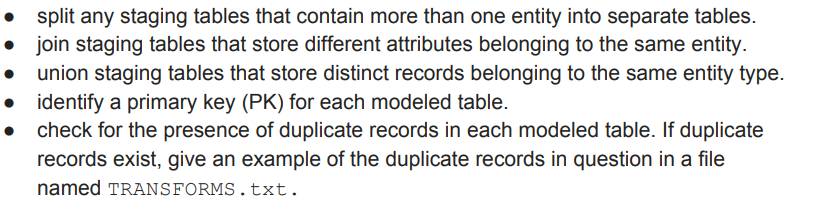

In [124]:
# Remove limit on number of columns shown
import pandas as pd
pd.set_option('display.max_columns', None)

### Split Demographic table into separate entities: Patient table, Manufacturer table, Adverse_Event table and Case table 

#### Create Patient table

In [98]:
%%bigquery
create or replace table faers_modeled.Patient as
select ROW_NUMBER() OVER(ORDER BY PRIMARYID) as PATIENT_ID, PRIMARYID as CASE_ID, SEX, AGE, AGE_COD as AGE_UNIT, AGE_GRP as AGE_GROUP, WT as WEIGHT, WT_COD as WEIGHT_UNIT 
from faers_staging.Demographic

""


In [141]:
%%bigquery
select * from faers_modeled.Patient

,PATIENT_ID,CASE_ID,SEX,AGE,AGE_UNIT,AGE_GROUP,WEIGHT,WEIGHT_UNIT
0,171,68158312,M,32,YR,None,NaN,None
1,206,69718655,F,85,YR,None,NaN,None
2,376,77051356,F,18,YR,None,NaN,None
3,1131,96488145,F,32,YR,None,64.919998,KG
4,1177,97467892,M,17,YR,None,NaN,None
...,...,...,...,...,...,...,...,...
394061,363876,157503071,M,84,YR,E,NaN,None
394062,368632,157557171,M,84,YR,None,NaN,None
394063,387912,157786831,F,84,YR,None,89.000000,KG
394064,389348,158222071,None,84,YR,None,NaN,None


#### Create Manufacturer table

In [145]:
%%bigquery
create or replace table faers_modeled.Manufacturer as
select ROW_NUMBER() OVER(ORDER BY MFR_SNDR) as MANU_ID, MFR_SNDR as DRUG_MANU 
from faers_staging.Demographic
group by MFR_SNDR

""


In [148]:
%%bigquery
select * from faers_modeled.Manufacturer
order by DRUG_MANU

,MANU_ID,DRUG_MANU
0,1,3M
1,2,AAA PHARMA
2,3,ABBVIE
3,4,ACADIA PHARMACEUTICALS
4,5,ACCESS
...,...,...
466,467,XIROMED
467,468,XTTRIUM
468,469,YUNG SHIN PHARMACEUTICAL
469,470,ZO SKIN HEALTH


#### Create Adverse_Event table by combining with Outcome table

In [151]:
%%bigquery
create or replace table faers_modeled.Adverse_Event as
select ROW_NUMBER() OVER(ORDER BY d.PRIMARYID) as EVENT_ID, d.PRIMARYID as CASE_ID, EVENT_DT_NUM as EVENT_DATE, OCCR_COUNTRY as COUNTRY, OUTC_COD as OUTCOME
from faers_staging.Demographic d left join faers_staging.Outcome o on d.primaryid = o.primaryid

""


In [152]:
%%bigquery
select * from faers_modeled.Adverse_Event

,EVENT_ID,CASE_ID,EVENT_DATE,COUNTRY,OUTCOME
0,1,36703554,None,BE,CA
1,4832,115186895,2000-01-11,FR,CA
2,5937,118586296,None,FR,CA
3,6931,121660918,None,FR,CA
4,14666,133369907,2004-11-02,FR,CA
...,...,...,...,...,...
463265,462636,1460936610,2018-07-02,CA,OT
463266,462712,1464829211,2017-10-23,FR,OT
463267,462770,1469008910,None,PL,OT
463268,462923,1484172811,2017-12-29,BE,OT


In [159]:
%%bigquery
select count(distinct case_id) from faers_modeled.Adverse_Event

,f0_
0,394066


#### Create Case (Report) table

In [153]:
%%bigquery
create or replace table faers_modeled.Case as
select PRIMARYID as CASE_ID, I_F_CODE as STATUS, REPT_COD as TYPE, REPT_DT_NUM as CASE_DATE, FDA_DT_NUM as FDA_DATE, MFR_DT_NUM as MANU_DATE, MANU_ID, TO_MFR as MANU_NOTIFD, OCCP_COD as REPORTER_OCCP, REPORTER_COUNTRY 
from faers_staging.Demographic d join faers_modeled.Manufacturer m on d.MFR_SNDR = m.DRUG_MANU 

""


In [154]:
%%bigquery
select * from faers_modeled.Case

,CASE_ID,STATUS,TYPE,CASE_DATE,FDA_DATE,MANU_DATE,MANU_ID,MANU_NOTIFD,REPORTER_OCCP,REPORTER_COUNTRY
0,156066741,I,DIR,None,2018-11-06,None,162,N,OT,US
1,156117181,I,DIR,None,2018-11-07,None,162,N,MD,US
2,156809361,I,DIR,None,2018-11-20,None,162,N,OT,US
3,157079191,I,DIR,None,2018-11-28,None,162,N,PH,US
4,157170581,I,DIR,None,2018-11-29,None,162,N,None,US
...,...,...,...,...,...,...,...,...,...,...
394061,155370741,I,DIR,2018-05-05,2018-10-16,None,162,N,CN,US
394062,158618321,I,DIR,2018-05-09,2018-12-31,None,162,N,OT,US
394063,158632541,I,DIR,2018-05-09,2018-12-31,None,162,N,OT,US
394064,155042791,I,DIR,2018-05-10,2018-10-09,None,162,N,CN,US


### Split Drug table into separate entities: Drug table (unique drug records), Active_Ingredient table and Administration (drug dispensing) table 

#### Create Drug table (with unique drug entries)

In [181]:
%%bigquery
create or replace table faers_modeled.Drug as 
select ROW_NUMBER() OVER() as DRUG_ID, DRUGNAME as DRUG_NAME
from faers_staging.Drug
group by DRUGNAME

""


In [187]:
%%bigquery
select * from faers_modeled.Drug
order by DRUG_ID

,DRUG_ID,DRUG_NAME
0,1,ANTIHEMOPHILIC FACTOR
1,2,TAXOTERE
2,3,DIGOXIN.
3,4,PREDNISOLONE.
4,5,PRAVASTATIN.
...,...,...
61839,61840,EFAVIRENZ MYLAN
61840,61841,"RIFADINE IV 600 MG, POUDRE ET SOLVANT POUR SOL..."
61841,61842,LITO
61842,61843,Ofloxacine


#### Create Active_Ingredient table

In [182]:
%%bigquery
create or replace table faers_modeled.Active_Ingredient as 
select ROW_NUMBER() OVER(ORDER BY PROD_AI) as INGREDIENT_ID, PROD_AI as ACTIVE_INGREDIENT
from faers_staging.Drug
group by PROD_AI

""


In [188]:
%%bigquery
select * from faers_modeled.Active_Ingredient
order by ACTIVE_INGREDIENT

,INGREDIENT_ID,ACTIVE_INGREDIENT
0,1,None
1,2,(1-743)-(1638-2332)-BLOOD-COAGULATION FACTOR V...
2,3,.ALPHA.-GLUCOSE-1-PHOSPHATE
3,4,.ALPHA.-LIPOIC ACID
4,5,.ALPHA.-PYRROLIDINOPENTIOPHENONE
...,...,...
5778,5779,ZOTEPINE
5779,5780,ZUCLOPENTHIXOL
5780,5781,ZUCLOPENTHIXOL ACETATE
5781,5782,ZUCLOPENTHIXOL DECANOATE


In [193]:
%%bigquery
# Delete 'None' record of Active_Ingredient
DELETE FROM faers_modeled.Active_Ingredient WHERE ACTIVE_INGREDIENT is null

""


In [194]:
%%bigquery
# Check if record deleted
select count(*) as Null_records from faers_modeled.Active_Ingredient WHERE ACTIVE_INGREDIENT is null

,Null_Records
0,0


#### Create Administration (administering of drug) table

In [269]:
%%bigquery
create or replace table faers_modeled.Administration as 
select ROW_NUMBER() OVER(ORDER BY PRIMARYID) as ADMIN_ID, PRIMARYID as CASE_ID, DRUG_ID, CAST(INGREDIENT_ID AS INT64) AS INGREDIENT_ID, DRUG_SEQ, ROLE_COD as DRUG_ROLE, LOT_NUM as DRUG_LOT, ROUTE as DRUG_ROUTE, DOSE_FORM, DOSE_FREQ, DOSE_AMT, DOSE_UNIT, CUM_DOSE_CHR as CUM_DOES, CUM_DOSE_UNIT, DECHAL, RECHAL  
from faers_staging.Drug d left join faers_modeled.Drug d2 on d.DRUGNAME = d2.DRUG_NAME
    left join faers_modeled.Active_Ingredient ai on d.PROD_AI = ai.ACTIVE_INGREDIENT

""


In [270]:
%%bigquery
select * from faers_modeled.Administration

,ADMIN_ID,CASE_ID,DRUG_ID,INGREDIENT_ID,DRUG_SEQ,DRUG_ROLE,DRUG_LOT,DRUG_ROUTE,DOSE_FORM,DOSE_FREQ,DOSE_AMT,DOSE_UNIT,CUM_DOES,CUM_DOSE_UNIT,DECHAL,RECHAL
0,10,37617136,688,3611.0,9,SS,None,Oral,TABLET,None,NaN,None,NaN,None,Y,None
1,20,39322722,7030,3372.0,2,SS,None,Subcutaneous,None,TIW,3.0,MIU,NaN,None,Y,None
2,173,61160272,1056,4506.0,11,C,None,Unknown,None,None,NaN,None,NaN,None,U,None
3,319,63078825,9331,4971.0,7,SS,UNKNOWN,Transplacental,"CAPSULE, SOFT",None,NaN,None,NaN,None,D,None
4,330,63111582,15,4765.0,5,C,None,Oral,None,QD,12.5,MG,NaN,None,U,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1546830,1546729,1546417011,11576,2425.0,15,SS,None,None,None,None,NaN,None,NaN,None,None,None
1546831,1546761,1549232712,1233,5541.0,14,SS,None,Oral,EXTENDED RELEASE TABLET,TID,5.5,MG,NaN,None,N,U
1546832,1546764,1549232712,1864,5275.0,26,C,None,Unknown,None,None,NaN,None,NaN,None,None,None
1546833,1546774,1549232712,1233,5541.0,16,SS,2101060,Oral,EXTENDED RELEASE TABLET,None,NaN,None,NaN,None,N,U


### Generate Primary Key for Reaction table and join with Case table for Foreign Key

In [230]:
%%bigquery
create or replace table faers_modeled.Reaction as 
select ROW_NUMBER() OVER(ORDER BY CASE_ID) as REACTION_ID, CASE_ID, PT as REACTION, DRUG_REC_ACT as RECUR_REACTION
from faers_staging.Reaction r left join faers_modeled.Case c on r.PRIMARYID = c.CASE_ID 

""


In [231]:
%%bigquery
select * from faers_modeled.Reaction

,REACTION_ID,CASE_ID,REACTION,RECUR_REACTION
0,55,39776825,Swelling,None
1,208,59983173,Haematemesis,None
2,233,60789672,Hypotension,None
3,242,61160272,Anuria,None
4,257,61160272,Liver function test increased,None
...,...,...,...,...
1250973,1145651,157561591,Wrong technique in product usage process,None
1250974,1146993,157567781,Wrong technique in product usage process,None
1250975,1148989,157577141,Wrong technique in product usage process,None
1250976,1160363,157628701,Wrong technique in product usage process,None


### Create Diagnosis table from Indication table and join with Administration table for Foreign Key

In [242]:
%%bigquery
create or replace table faers_modeled.Diagnosis as 
select ROW_NUMBER() OVER(ORDER BY ADMIN_ID) as DIAGNOSIS_ID, ADMIN_ID, INDI_PT as DIAGNOSIS
from faers_staging.Indication i left join faers_modeled.Administration a on i.PRIMARYID = a.CASE_ID and i.INDI_DRUG_SEQ = a.DRUG_SEQ 

""


In [243]:
%%bigquery
select * from faers_modeled.Diagnosis

,DIAGNOSIS_ID,ADMIN_ID,DIAGNOSIS
0,224,298,Prophylaxis against graft versus host disease
1,329,430,Sedation
2,397,526,Congestive cardiomyopathy
3,743,1027,Colorectal cancer metastatic
4,892,1239,Renal transplant
...,...,...,...
1064659,1064040,1545857,Product used for unknown indication
1064660,1064076,1545924,Product used for unknown indication
1064661,1064145,1546028,Product used for unknown indication
1064662,1064477,1546544,Product used for unknown indication


### Identify Primary Key (PK) for each modeled table

#### Patient table : PK is PATIENT_ID

In [244]:
%%bigquery
select count(*) as total_records from faers_modeled.Patient

,total_records
0,394066


In [245]:
%%bigquery
select count(distinct PATIENT_ID) as distinct_id from faers_modeled.Patient

,distinct_id
0,394066


#### Manufacturer table : PK is MANU_ID

In [246]:
%%bigquery
select count(*) as total_records from faers_modeled.Manufacturer

,total_records
0,471


In [247]:
%%bigquery
select count(distinct MANU_ID) as distinct_id from faers_modeled.Manufacturer

,distinct_id
0,471


#### Case table : PK is CASE_ID

In [248]:
%%bigquery
select count(*) as total_records from faers_modeled.Case

,total_records
0,394066


In [249]:
%%bigquery
select count(distinct CASE_ID) as distinct_id from faers_modeled.Case

,distinct_id
0,394066


#### Adverse_Event table : PK is EVENT_ID

In [250]:
%%bigquery
select count(*) as total_records from faers_modeled.Adverse_Event

,total_records
0,463270


In [251]:
%%bigquery
select count(distinct EVENT_ID) as distinct_id from faers_modeled.Adverse_Event

,distinct_id
0,463270


#### Drug table : PK is DRUG_ID

In [252]:
%%bigquery
select count(*) as total_records from faers_modeled.Drug

,total_records
0,61844


In [253]:
%%bigquery
select count(distinct DRUG_ID) as distinct_id from faers_modeled.Drug

,distinct_id
0,61844


#### Active_Ingredient table : PK is INGREDIENT_ID

In [254]:
%%bigquery
select count(*) as total_records from faers_modeled.Active_Ingredient

,total_records
0,5783


In [255]:
%%bigquery
select count(distinct INGREDIENT_ID) as distinct_id from faers_modeled.Active_Ingredient

,distinct_id
0,5783


#### Administration table : PK is ADMIN_ID

In [256]:
%%bigquery
select count(*) as total_records from faers_modeled.Administration

,total_records
0,1546835


In [257]:
%%bigquery
select count(distinct ADMIN_ID) as distinct_id from faers_modeled.Administration

,distinct_id
0,1546835


#### Reaction table : PK is REACTION_ID

In [258]:
%%bigquery
select count(*) as total_records from faers_modeled.Reaction

,total_records
0,1250978


In [259]:
%%bigquery
select count(distinct REACTION_ID) as distinct_id from faers_modeled.Reaction

,distinct_id
0,1250978


#### Diagnosis table : PK is DIAGNOSIS_ID

In [260]:
%%bigquery
select count(*) as total_records from faers_modeled.Diagnosis

,total_records
0,1064664


In [261]:
%%bigquery
select count(distinct DIAGNOSIS_ID) as distinct_id from faers_modeled.Diagnosis

,distinct_id
0,1064664


### Check for referential integrity violations 

In [262]:
%%bigquery
select count(*) as count_of_missing_PK
from faers_modeled.Patient p left join faers_modeled.Case c on p.CASE_ID = c.CASE_ID
where c.CASE_ID is null

,count_of_missing_PK
0,0


In [263]:
%%bigquery
select count(*) as count_of_missing_PK
from faers_modeled.Case c left join faers_modeled.Manufacturer m on c.MANU_ID = m.MANU_ID
where m.MANU_ID is null

,count_of_missing_PK
0,0


In [264]:
%%bigquery
select count(*) as count_of_missing_PK
from faers_modeled.Adverse_Event a left join faers_modeled.Case c on a.CASE_ID = c.CASE_ID
where c.CASE_ID is null

,count_of_missing_PK
0,0


In [265]:
%%bigquery
select count(*) as count_of_missing_PK
from faers_modeled.Administration a left join faers_modeled.Drug d on a.DRUG_ID = d.DRUG_ID
where d.DRUG_ID is null

,count_of_missing_PK
0,0


In [271]:
%%bigquery
select count(*) as count_of_missing_PK
from faers_modeled.Diagnosis d left join faers_modeled.Administration a on d.ADMIN_ID = a.ADMIN_ID
where a.ADMIN_ID is null

,count_of_missing_PK
0,0


In [272]:
%%bigquery
select count(*) as count_of_missing_PK
from faers_modeled.Reaction r left join faers_modeled.Case c on r.CASE_ID = c.CASE_ID
where c.CASE_ID is null

,count_of_missing_PK
0,0
